In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Example').getOrCreate()

24/06/19 22:24:05 WARN Utils: Your hostname, Ugurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.7 instead (on interface en0)
24/06/19 22:24:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/19 22:24:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [51]:
spark

In [69]:
spark.sparkContext.uiWebUrl

'http://172.20.10.7:4040'

In [73]:
spark.sparkContext.startTime

1718825046290

In [79]:
dir(spark.sparkContext.statusTracker)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

                                             SPILL TEST

In [49]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark.sparkContext.setJobDescription('spill')  # Setting Job description
data = range(0, 10000000)
# Create DataFrame with a lot of records
df = spark.createDataFrame(data, "int").toDF("id")
df.cache().count()

# Create a temporary view so we can run SQL queries
df.createOrReplaceTempView("records")

# Force a spill. The high number of partitions and usage of `UNION ALL`
# will generate a big number of records in memory
df2 = spark.sql("""
    SELECT /*+ REPARTITION(1000) */ id 
    FROM records 
    UNION ALL 
    SELECT /*+ REPARTITION(1000) */ id 
    FROM records
""")
df2.cache().count()

24/06/19 22:30:58 WARN TaskSetManager: Stage 0 contains a task of very large size (6737 KiB). The maximum recommended task size is 1000 KiB.
24/06/19 22:31:03 WARN TaskSetManager: Stage 1 contains a task of very large size (6737 KiB). The maximum recommended task size is 1000 KiB.
24/06/19 22:31:05 WARN TaskSetManager: Stage 4 contains a task of very large size (6737 KiB). The maximum recommended task size is 1000 KiB.
24/06/19 22:31:10 WARN TaskSetManager: Stage 5 contains a task of very large size (6737 KiB). The maximum recommended task size is 1000 KiB.


20000000

                                                    SKEW TEST

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
import random

# Spark session oluşturuluyor
spark.sparkContext.setJobDescription('skew')  # Setting Job description
sc = spark.sparkContext

# Büyük bir RDD yaratılıyor
rdd = sc.parallelize([(i, random.randint(0,1000000)) for i in range(10000000)])

# Key'ler bazen aynı olacak şekilde RDD'ye bozuk veri ekleniyor
rdd = rdd.union(sc.parallelize([(0, i) for i in range(1000000)]))

# Reduce operasyonunda shuffle ve skewed data oluştuğundan emin olunur
result_rdd = rdd.reduceByKey(lambda a, b: a + b)

result_rdd.collect()

                                            SMALL FILES TEST

In [8]:
spark.sparkContext.setJobDescription('scan tiny files')  # Setting Job description

weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")
weather.filter(weather["year"]==2022).count()

450787193

In [9]:
spark.sparkContext.setJobDescription('scan tiny files 3')  # Setting Job description

weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")
weather.count()

3604627124

In [10]:
spark.sparkContext.setJobDescription('scan tiny files 2')  # Setting Job description

df_str = spark.read.parquet("/Users/ugurkalkavan/tmp/df_str")
df_str.count()

100000000

                                            APP STARTS

In [20]:
from sparkpyrest.spark_pyrest import SparkPyRest

spr = SparkPyRest("localhost")

In [22]:
spr


        -- app will give you the app id
        -- Stage will give you the stage info
        -- Job will give you the job info
        -- Tasks(stageId) will give you the task info
        -- sql will give you the sql info

In [24]:
spr.app

'local-1718580653657'

In [9]:
spr.jobs

display() will give you the job info

In [11]:
spr.jobs.display()

,jobId,name,description,stageIds
0,7,count at NativeMethodAccessorImpl.java:0,spill,"[15, 12, 13, 14]"
1,6,count at NativeMethodAccessorImpl.java:0,spill,"[9, 10, 11]"
2,5,count at NativeMethodAccessorImpl.java:0,spill,"[6, 7, 8]"
3,4,count at NativeMethodAccessorImpl.java:0,spill,[5]
4,3,count at NativeMethodAccessorImpl.java:0,spill,[4]
5,2,count at NativeMethodAccessorImpl.java:0,spill,"[2, 3]"
6,1,count at NativeMethodAccessorImpl.java:0,spill,[1]
7,0,count at NativeMethodAccessorImpl.java:0,spill,[0]


In [12]:
spr.stages

display() will give you the stage info

spr.stages.display()[['stageId','description','quantiles', 'duration', 'executorDeserializeTime', 'executorDeserializeCpuTime', 'executorRunTime', 'executorCpuTime', 'resultSize', 'jvmGcTime', 'resultSerializationTime', 'gettingResultTime', 'schedulerDelay', 'peakExecutionMemory', 'memoryBytesSpilled', 'diskBytesSpilled', 'bytesRead', 'recordsRead', 'bytesWritten', 'recordsWritten', 
                     'readBytes', 'readRecords']]




In [15]:
spr.stages.display()

,jobId,description,status,stageId,attemptId,numTasks,numActiveTasks,numCompleteTasks,numFailedTasks,numKilledTasks,...,taskMetricsDistributions.inputMetrics.bytesRead,taskMetricsDistributions.inputMetrics.recordsRead,taskMetricsDistributions.outputMetrics.bytesWritten,taskMetricsDistributions.outputMetrics.recordsWritten,taskMetricsDistributions.shuffleReadMetrics.readBytes,taskMetricsDistributions.shuffleReadMetrics.readRecords,taskMetricsDistributions.shuffleWriteMetrics.writeBytes,taskMetricsDistributions.shuffleWriteMetrics.writeRecords,taskMetricsDistributions.shuffleWriteMetrics.writeTime,executorMetricsDistributions.quantiles
0,7,spill,COMPLETE,15,0,1,0,1,0,0,...,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[11800.0, 11800.0, 11800.0, 11800.0, 11800.0]","[200.0, 200.0, 200.0, 200.0, 200.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.25, 0.5, 0.75, 1.0]"
1,7,spill,SKIPPED,12,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,spill,SKIPPED,13,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,spill,SKIPPED,14,0,200,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,spill,SKIPPED,9,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,spill,SKIPPED,10,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,spill,COMPLETE,11,0,200,0,200,0,0,...,"[4224.0, 4240.0, 4240.0, 4248.0, 4248.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[59.0, 59.0, 59.0, 59.0, 59.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[172959.0, 470540.0, 1234125.0, 3198500.0, 251...","[0.0, 0.25, 0.5, 0.75, 1.0]"
7,5,spill,SKIPPED,6,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5,spill,SKIPPED,7,0,10,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5,spill,COMPLETE,8,0,200,0,200,0,0,...,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[6757.0, 6845.0, 6935.0, 6971.0, 7031.0]","[998.0, 1000.0, 1000.0, 1001.0, 1002.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.25, 0.5, 0.75, 1.0]"


from ydata_profiling import ProfileReport
stages_df = spr.stages.display()
report = ProfileReport(stages_df, title="Profiling pyspark DataFrame")
report

In [ ]:
spr.stages.display()[['jobId','description','stageId','memoryBytesSpilled', 'diskBytesSpilled']]

In [ ]:
df = spr.stages.display()[['jobId','description','stageId','memoryBytesSpilled', 'diskBytesSpilled']]


In [ ]:
spr.stages.analyze()

In [ ]:
spr.stages.display()

In [77]:
spr.tasks

,jobId,description,stageId,firstTaskLaunchedTime,completionTime,taskId,index,attempt,partitionId,launchTime,...,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.localMergedBlocksFetched,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.remoteMergedChunksFetched,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.localMergedChunksFetched,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.remoteMergedBytesRead,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.localMergedBytesRead,taskMetrics.shuffleReadMetrics.shufflePushReadMetrics.remoteMergedReqsDuration,taskMetrics.shuffleWriteMetrics.bytesWritten,taskMetrics.shuffleWriteMetrics.recordsWritten,schedulerDelay,gettingResultTime
0,17,scan tiny files 2,29,2024-06-16T15:22:37.143GMT,2024-06-16T15:22:37.152GMT,4653,0,0,0,2024-06-16T15:22:37.143GMT,...,0,0,0,0,0,0,0,0,2,0
1,16,scan tiny files 2,27,2024-06-16T15:22:36.896GMT,2024-06-16T15:22:37.117GMT,4647,4,0,4,2024-06-16T15:22:36.898GMT,...,0,0,0,0,0,0,56,1,16,0
2,16,scan tiny files 2,27,2024-06-16T15:22:36.896GMT,2024-06-16T15:22:37.117GMT,4650,7,0,7,2024-06-16T15:22:36.898GMT,...,0,0,0,0,0,0,56,1,17,0
3,16,scan tiny files 2,27,2024-06-16T15:22:36.896GMT,2024-06-16T15:22:37.117GMT,4643,0,0,0,2024-06-16T15:22:36.896GMT,...,0,0,0,0,0,0,56,1,23,0
4,16,scan tiny files 2,27,2024-06-16T15:22:36.896GMT,2024-06-16T15:22:37.117GMT,4648,5,0,5,2024-06-16T15:22:36.898GMT,...,0,0,0,0,0,0,56,1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,0,spill,0,2024-06-16T15:21:47.264GMT,2024-06-16T15:21:52.430GMT,2,2,0,2,2024-06-16T15:21:47.332GMT,...,0,0,0,0,0,0,0,0,312,0
4650,0,spill,0,2024-06-16T15:21:47.264GMT,2024-06-16T15:21:52.430GMT,7,7,0,7,2024-06-16T15:21:47.374GMT,...,0,0,0,0,0,0,0,0,237,0
4651,0,spill,0,2024-06-16T15:21:47.264GMT,2024-06-16T15:21:52.430GMT,3,3,0,3,2024-06-16T15:21:47.346GMT,...,0,0,0,0,0,0,0,0,269,0
4652,0,spill,0,2024-06-16T15:21:47.264GMT,2024-06-16T15:21:52.430GMT,8,8,0,8,2024-06-16T15:21:47.377GMT,...,0,0,0,0,0,0,0,0,267,0


In [201]:
df = spr.tasks
filtered_df = df[df['taskMetrics.jvmGcTime'] > 100]

In [205]:
filtered_df[['jobId','description','duration','stageId','taskLocality','taskMetrics.jvmGcTime','taskMetrics.resultSerializationTime',
             'taskMetrics.memoryBytesSpilled','taskMetrics.diskBytesSpilled']]


,jobId,description,duration,stageId,taskLocality,taskMetrics.jvmGcTime,taskMetrics.resultSerializationTime,taskMetrics.memoryBytesSpilled,taskMetrics.diskBytesSpilled
572,8,skew,2740,16,PROCESS_LOCAL,134,8,0,0
574,8,skew,2722,16,PROCESS_LOCAL,134,5,0,0
575,8,skew,2681,16,PROCESS_LOCAL,134,0,0,0
578,8,skew,2735,16,PROCESS_LOCAL,134,2,0,0
580,8,skew,2686,16,PROCESS_LOCAL,134,0,0,0
581,8,skew,2669,16,PROCESS_LOCAL,134,5,0,0
585,8,skew,2718,16,PROCESS_LOCAL,134,10,0,0
587,8,skew,2724,16,PROCESS_LOCAL,134,3,0,0
589,8,skew,2744,16,PROCESS_LOCAL,134,9,0,0
590,8,skew,2676,16,PROCESS_LOCAL,134,0,0,0


In [118]:
filtered_df[['jobId','description','stageId','taskMetrics.peakExecutionMemory','taskMetrics.memoryBytesSpilled','taskMetrics.diskBytesSpilled']]

,jobId,description,stageId,taskMetrics.peakExecutionMemory,taskMetrics.memoryBytesSpilled,taskMetrics.diskBytesSpilled
13,13,scan tiny files 3,23,0,0,0
15,13,scan tiny files 3,23,0,0,0
16,13,scan tiny files 3,23,0,0,0
17,13,scan tiny files 3,23,0,0,0
18,13,scan tiny files 3,23,0,0,0
...,...,...,...,...,...,...
4649,0,spill,0,0,0,0
4650,0,spill,0,0,0,0
4651,0,spill,0,0,0,0
4652,0,spill,0,0,0,0


In [79]:
spr.tasks.columns

Index(['jobId', 'description', 'stageId', 'firstTaskLaunchedTime',
       'completionTime', 'taskId', 'index', 'attempt', 'partitionId',
       'launchTime', 'duration', 'executorId', 'host', 'status',
       'taskLocality', 'speculative', 'accumulatorUpdates',
       'taskMetrics.executorDeserializeTime',
       'taskMetrics.executorDeserializeCpuTime', 'taskMetrics.executorRunTime',
       'taskMetrics.executorCpuTime', 'taskMetrics.resultSize',
       'taskMetrics.jvmGcTime', 'taskMetrics.resultSerializationTime',
       'taskMetrics.memoryBytesSpilled', 'taskMetrics.diskBytesSpilled',
       'taskMetrics.peakExecutionMemory', 'taskMetrics.inputMetrics.bytesRead',
       'taskMetrics.inputMetrics.recordsRead',
       'taskMetrics.outputMetrics.bytesWritten',
       'taskMetrics.outputMetrics.recordsWritten',
       'taskMetrics.shuffleReadMetrics.remoteBlocksFetched',
       'taskMetrics.shuffleReadMetrics.localBlocksFetched',
       'taskMetrics.shuffleReadMetrics.fetchWaitTime',
 

In [53]:
def actual_duration(df):
    # Convert 'firstTaskLaunchedTime' and 'completionTime' to datetime
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime'])
    df['completionTime'] = pd.to_datetime(df['completionTime'])

    # Group by 'stageId' and find min 'firstTaskLaunchedTime' and max 'completionTime'
    df_grouped = df.groupby('stageId').agg({'firstTaskLaunchedTime': 'min', 'completionTime': 'max'}).reset_index()

    # Duration is the difference between 'completionTime' and 'firstTaskLaunchedTime' for each 'stageId'
    df_grouped['duration'] = df_grouped['completionTime'] - df_grouped['firstTaskLaunchedTime']

    # Sum of all durations
    total_time = df_grouped['duration'].sum()

    return total_time

In [55]:
actual_duration(spr.tasks)

Timedelta('0 days 00:00:37.290000')

In [31]:
import pandas as pd
def critical_path_duration(df):
    # Convert 'completionTime' to datetime
    df['completionTime'] = pd.to_datetime(df['completionTime'])

    # Convert 'duration' to timedelta (in ms)
    df['duration'] = pd.to_timedelta(df['duration'], unit='ms')

    # Group by 'stageId' and find max 'duration'
    max_duration = df.groupby('stageId')['duration'].max()
    critical_path_duration = max_duration.sum()
    
    # Convert 'firstTaskLaunchedTime' to datetime
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime'])
    
    # Get the first value of 'firstTaskLaunchedTime'
    first_task_time = df['firstTaskLaunchedTime'].min()
    
    # Add it to 'critical_path_duration'
    total_time = critical_path_duration + first_task_time

    return critical_path_duration


In [269]:
critical_path_duration(spr.tasks)

0 days 00:00:19.234000


Timedelta('0 days 00:00:19.234000')

In [33]:
import pandas as pd

def single_core_duration(df):
    # Convert 'completionTime' to datetime
    df['completionTime'] = pd.to_datetime(df['completionTime'])

    # Convert 'duration' to timedelta (in ms)
    df['duration'] = pd.to_timedelta(df['duration'], unit='ms')

    # Sum all 'duration'
    single_core_duration = df['duration'].sum()

    # Convert 'firstTaskLaunchedTime' to datetime
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime'])
    
    # Get the first value of 'firstTaskLaunchedTime'
    first_task_time = df['firstTaskLaunchedTime'].min()
    
    # Add it to 'single_core_duration'
    total_time = single_core_duration + first_task_time
    
    return single_core_duration

In [155]:
single_core_duration(spr.tasks)

0 days 00:04:02.885000


Timestamp('2024-06-15 21:44:47.952000')

In [35]:
import pandas as pd
def ideal_path_duration(df):
    # Convert 'completionTime' to datetime
    df['completionTime'] = pd.to_datetime(df['completionTime'])

    # Convert 'duration' to timedelta (in ms)
    df['duration'] = pd.to_timedelta(df['duration'], unit='ms')

    # Group by 'stageId' and find max 'duration'
    avg_duration = df.groupby('stageId')['duration'].mean()
    ideal_path_duration = avg_duration.sum()
    
    # Convert 'firstTaskLaunchedTime' to datetime
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime'])
    
    # Get the first value of 'firstTaskLaunchedTime'
    first_task_time = df['firstTaskLaunchedTime'].min()
    
    # Add it to 'critical_path_duration'
    total_time = ideal_path_duration + first_task_time
    
    return ideal_path_duration


In [151]:
ideal_path_duration(spr.tasks)

0 days 00:00:14.749889500


Timestamp('2024-06-15 21:40:59.816889500')

In [111]:
import numpy as np
import pandas as pd
import math

def create_duration_df(df, n):
    df['duration'] = pd.to_timedelta(df['duration'], unit='ms') 
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime'])  

    first_task_time = df['firstTaskLaunchedTime'].min()

    rows = []

    for stageId, group in df.groupby('stageId'):
        sorted_group = group.sort_values('duration', ascending=False)

        split = math.ceil(len(group) / n)

        parts = np.array_split(sorted_group, split)

        for i, part in enumerate(parts):
            max_duration = part['duration'].max()
            row = {'stageId': stageId, 'task_duration_group': i+1, 'duration': max_duration}
            rows.append(row)

    result_df = pd.DataFrame(rows)

    # Add min firstTaskLaunchedTime to each duration, cumulatively
    result_df['cumulative_duration'] = result_df['duration'].cumsum() + first_task_time

    #print(result_df['duration'].sum())
    return result_df

In [114]:
create_duration_df(spr.tasks, 100)

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,stageId,task_duration_group,duration,cumulative_duration
0,0,1,0 days 00:00:08.762000,2024-06-15 21:40:53.829
1,1,1,0 days 00:00:01.181000,2024-06-15 21:40:55.010
2,3,1,0 days 00:00:00.190000,2024-06-15 21:40:55.200
3,4,1,0 days 00:00:05.915000,2024-06-15 21:41:01.115
4,5,1,0 days 00:00:02.578000,2024-06-15 21:41:03.693
5,8,1,0 days 00:00:00.313000,2024-06-15 21:41:04.006
6,8,2,0 days 00:00:00.079000,2024-06-15 21:41:04.085
7,8,3,0 days 00:00:00.063000,2024-06-15 21:41:04.148
8,8,4,0 days 00:00:00.056000,2024-06-15 21:41:04.204
9,8,5,0 days 00:00:00.049000,2024-06-15 21:41:04.253


In [25]:
import pandas as pd
import math

def create_duration_df(df, n):
    df['duration'] = pd.to_timedelta(df['duration'], unit='ms') 
    df['firstTaskLaunchedTime'] = pd.to_datetime(df['firstTaskLaunchedTime']) 

    first_task_time = df['firstTaskLaunchedTime'].min()
    rows = []

    for stageId, group in df.groupby('stageId'):
        sorted_group = group.sort_values('duration', ascending=False)

        split_size = math.ceil(len(group) / n)

        for i in range(split_size):
            start = i * n
            end = start + n
            part = sorted_group.iloc[start:end]

            if part.empty:
                continue

            max_duration = part['duration'].max()
            row = {'stageId': stageId, 'task_duration_group': i+1, 'duration': max_duration}
            rows.append(row)

    result_df = pd.DataFrame(rows)
    result_df['cumulative_duration'] = result_df['duration'].cumsum() + first_task_time

    return result_df

In [161]:
create_duration_df(spr.tasks, 1000)

,stageId,task_duration_group,duration,cumulative_duration
0,0,1,0 days 00:00:08.762000,2024-06-15 21:40:53.829
1,1,1,0 days 00:00:01.181000,2024-06-15 21:40:55.010
2,3,1,0 days 00:00:00.190000,2024-06-15 21:40:55.200
3,4,1,0 days 00:00:05.915000,2024-06-15 21:41:01.115
4,5,1,0 days 00:00:02.578000,2024-06-15 21:41:03.693
5,8,1,0 days 00:00:00.313000,2024-06-15 21:41:04.006
6,8,2,0 days 00:00:00.026000,2024-06-15 21:41:04.032
7,11,1,0 days 00:00:00.185000,2024-06-15 21:41:04.217
8,11,2,0 days 00:00:00.010000,2024-06-15 21:41:04.227
9,15,1,0 days 00:00:00.110000,2024-06-15 21:41:04.337


In [172]:
import pandas as pd

def optimize_duration(df):
    max_n = len(df)
   
    best_n = 1
    best_duration = create_duration_df(df, 1)['duration'].sum()
    durations = []
    results = []
    actual_time =  actual_duration(df)
    critical_path_time = critical_path_duration(df)
    ideal_path_time = ideal_path_duration(df)
    single_core_time = single_core_duration(df)

    print("Actual time :-----", actual_time)
    print("Single core time :-----", single_core_time)
    print("Critical path time :-----", critical_path_time)
    print("Perfect path time :-----", ideal_path_time)
    
    print()
    print(best_n, "-----", best_duration)


    critical_path_time = critical_path_time.total_seconds() * 1000
    ideal_path_time = ideal_path_time.total_seconds() * 1000
    single_core_time = single_core_time.total_seconds() * 1000
    
    results.append({'best_n': best_n, 'best_duration': best_duration})
    

    step = 1  
    for n in range(1, max_n, step):
        current_duration = create_duration_df(df, n)['duration'].sum()
        durations.append(current_duration / pd.Timedelta(milliseconds=1))

        if len(durations) > 1:
            # If the relative change is less than 5%, or duration is within 5% of the critical path,
            # break the loop
            if (np.abs((durations[-1] - durations[-2]) / durations[-2]) < 0.05) \
            and (np.abs((durations[-1] - critical_path_time) / critical_path_time) < 0.1):
                break

        if current_duration < best_duration:
            best_duration = current_duration
            best_n = n

        results.append({'best_n': best_n, 'best_duration': best_duration})
        
        print(n, "-----", current_duration)

        if n > 1:  
            step = n  

    print("BEST: ", best_n, "-----", best_duration)
    
    return pd.DataFrame(results)

In [174]:
import numpy as np
optimize_duration(spr.tasks) 

Actual time :----- 0 days 00:00:37.290000
Single core time :----- 0 days 00:06:14.016000
Critical path time :----- 0 days 00:00:23.531000
Perfect path time :----- 0 days 00:00:19.907084038

1 ----- 0 days 00:06:14.016000
1 ----- 0 days 00:06:14.016000
2 ----- 0 days 00:03:08.021000
3 ----- 0 days 00:02:19
4 ----- 0 days 00:01:44.599000
5 ----- 0 days 00:01:16.643000
6 ----- 0 days 00:01:11.239000
7 ----- 0 days 00:01:06.233000
8 ----- 0 days 00:01:03.468000
9 ----- 0 days 00:01:01.254000
10 ----- 0 days 00:00:39.415000
11 ----- 0 days 00:00:37.959000
12 ----- 0 days 00:00:36.807000
13 ----- 0 days 00:00:35.826000
14 ----- 0 days 00:00:35.022000
15 ----- 0 days 00:00:34.282000
16 ----- 0 days 00:00:33.592000
17 ----- 0 days 00:00:33.056000
18 ----- 0 days 00:00:32.583000
19 ----- 0 days 00:00:32.140000
20 ----- 0 days 00:00:30.414000
21 ----- 0 days 00:00:30.037000
22 ----- 0 days 00:00:29.729000
23 ----- 0 days 00:00:29.464000
24 ----- 0 days 00:00:29.201000
25 ----- 0 days 00:00:28.96

,best_n,best_duration
0,1,0 days 00:06:14.016000
1,1,0 days 00:06:14.016000
2,2,0 days 00:03:08.021000
3,3,0 days 00:02:19
4,4,0 days 00:01:44.599000
5,5,0 days 00:01:16.643000
6,6,0 days 00:01:11.239000
7,7,0 days 00:01:06.233000
8,8,0 days 00:01:03.468000
9,9,0 days 00:01:01.254000


In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_df(df):
    # Convert duration to total seconds format
    df['time'] = df['best_duration'].dt.total_seconds()/60
    
    # Get column names
    x_col = df.columns[0]

    # Increase the size of the plot
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=df[x_col], y=df['time'], marker="o",markerfacecolor='blue')
    plt.xlabel(x_col)
    plt.ylabel('Duration (minutes)')


    plt.show()

Actual time :----- 0 days 00:00:37.290000
Single core time :----- 0 days 00:06:14.016000
Critical path time :----- 0 days 00:00:23.531000
Perfect path time :----- 0 days 00:00:19.907084038

1 ----- 0 days 00:06:14.016000
1 ----- 0 days 00:06:14.016000
2 ----- 0 days 00:03:08.021000
3 ----- 0 days 00:02:19
4 ----- 0 days 00:01:44.599000
5 ----- 0 days 00:01:16.643000
6 ----- 0 days 00:01:11.239000
7 ----- 0 days 00:01:06.233000
8 ----- 0 days 00:01:03.468000
9 ----- 0 days 00:01:01.254000
10 ----- 0 days 00:00:39.415000
11 ----- 0 days 00:00:37.959000
12 ----- 0 days 00:00:36.807000
13 ----- 0 days 00:00:35.826000
14 ----- 0 days 00:00:35.022000
15 ----- 0 days 00:00:34.282000
16 ----- 0 days 00:00:33.592000
17 ----- 0 days 00:00:33.056000
18 ----- 0 days 00:00:32.583000
19 ----- 0 days 00:00:32.140000
20 ----- 0 days 00:00:30.414000
21 ----- 0 days 00:00:30.037000
22 ----- 0 days 00:00:29.729000
23 ----- 0 days 00:00:29.464000
24 ----- 0 days 00:00:29.201000
25 ----- 0 days 00:00:28.96

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


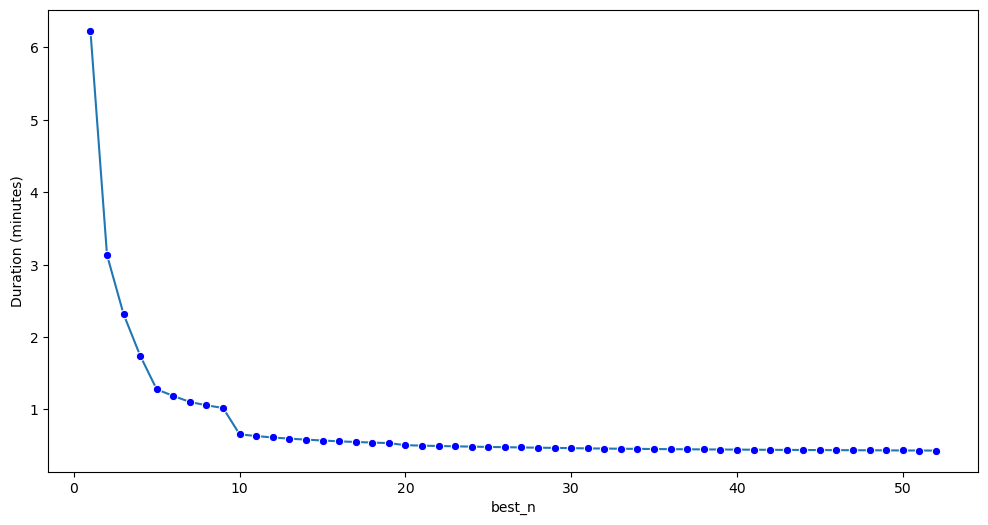

In [178]:
df = optimize_duration(spr.tasks) 
plot_df(df)

In [179]:
spr.examine()

0

In [ ]:
spr.sql.display()[['id','nodeId','nodeName','name','value']]

In [ ]:
spr.sql.display()[['id','nodeId','nodeName','name','value']].groupby('nodeId').describe()

In [ ]:
spr.sql.analyze()

In [ ]:
spr.tasks(15)

In [ ]:
host_tasks = spr.tasks(1)[['host','bytesWritten','remoteBytesRead','executorRunTime']].groupby('host')

host_tasks.describe()

In [ ]:
host_tasks = spr.tasks(8)[['host','bytesWritten']].groupby('host')

host_tasks.describe()

In [ ]:
mean_runtime = host_tasks.mean()['bytesWritten']

mean_runtime.plot(kind='bar')